In [64]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import numpy as np

def plot_attention_histogram(attention_scores, layer_num):
    # Flatten the attention scores to a single list
    attention_values = [score.item() for scores in attention_scores for score in scores.flatten()]
    plt.figure(figsize=(10, 6))
    plt.hist(attention_values, bins=50, alpha=0.75)
    plt.title(f'Attention Score Distribution - Layer {layer_num}')
    plt.xlabel('Attention Scores')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

def plot_attention_piechart(attention_scores, layer_num):
    # Flatten the attention scores to a single list
    attention_values = [score.item() for scores in attention_scores for score in scores.flatten()]
    
    # Calculate histogram data
    hist, bin_edges = np.histogram(attention_values, bins=50)
    
    # Calculate percentage of each bin
    percentages = hist / hist.sum() * 100
    
    # Create pie chart
    plt.figure(figsize=(10, 6))
    plt.pie(percentages, labels=[f'{edge:.2f}-{bin_edges[i+1]:.2f}' for i, edge in enumerate(bin_edges[:-1])], autopct='%1.1f%%')
    plt.title(f'Attention Score Distribution - Layer {layer_num}')
    plt.show()


### TODO: Load in datasets to see how to sparsify v for 
- One coding dataset
- One wiki dataset
- One general internet dataset
- One dialogue/assistant dataset

### TODO: Figure out metrics to see how many logits is needed to be 80, 90, 95, 99%
### TODO: Run metrics across different sequence lengths
- Find max seq length and use prefixes of it
- report metrics at intermediate sequence lengths
  - ex). on __ sequences, these are the metrics for __ sequence length
- Track worst case (sparsity) - when the data is not sparse b/c all the logits are close
  - more evenly distrubuted logits


In [26]:
# Load tokenizer and model
model_name = "gpt2"  # Example model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, output_attentions=True)
# Encode input and create tensors
input_text = """
Once upon a time, in a land full of trees, there was a little cherry tree. The cherry tree was very sad because it did not have any friends. All the other trees were big and strong, but the cherry tree was small and weak. The cherry tree was envious of the big trees. One day, the cherry tree felt a tickle in its branches. It was a little spring wind. The wind told the cherry tree not to be sad. The wind said, "You are special because you have sweet cherries that everyone loves." The cherry tree started to feel a little better. As time went on, the cherry tree grew more and more cherries. All the animals in the land came to eat the cherries and play under the cherry tree. The cherry tree was happy because it had many friends now. The cherry tree learned that being different can be a good thing. And they all lived happily ever after.
"""
inputs = tokenizer(input_text, return_tensors="pt")

# Run the model
with torch.no_grad():
    outputs = model(**inputs)

# Get the attentions
attentions = outputs.attentions  # Tuple of tensors: one for each layer

# make a tril matrix of size [sequence_length, sequence_length]
sequence_length = attentions[0].shape[-1]
mask = torch.tril(torch.ones(sequence_length, sequence_length) == 1)

191

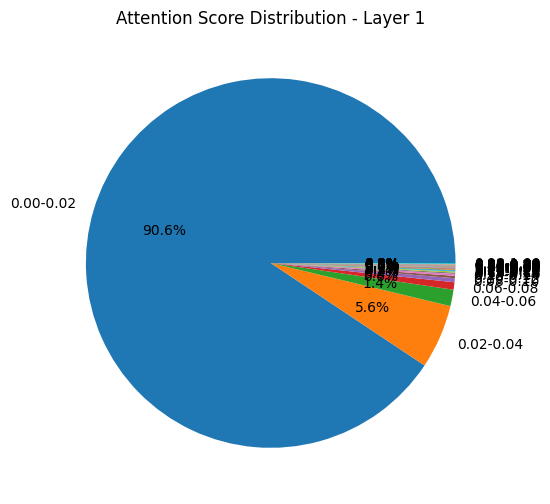

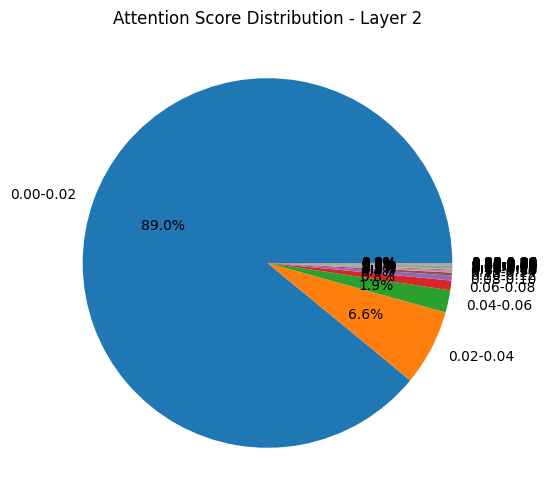

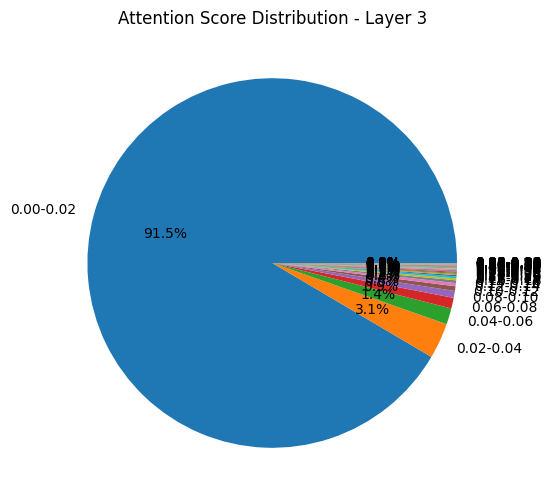

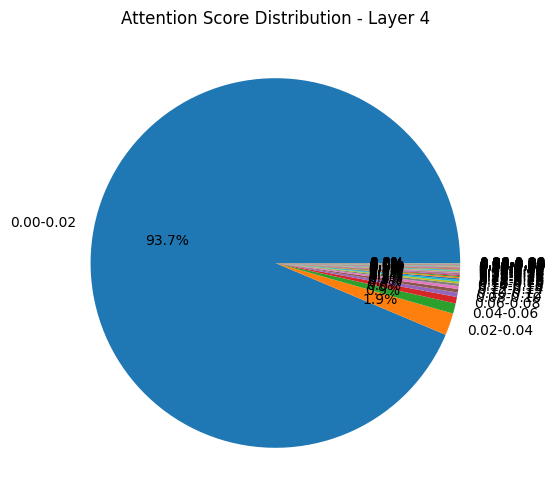

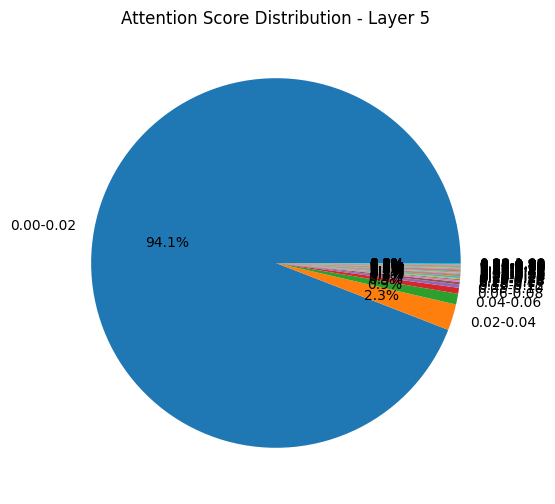

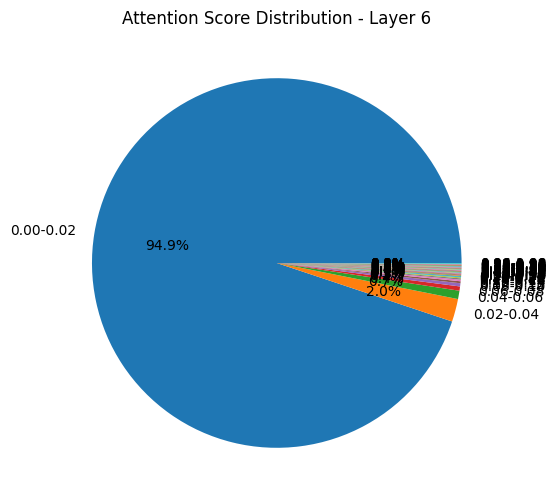

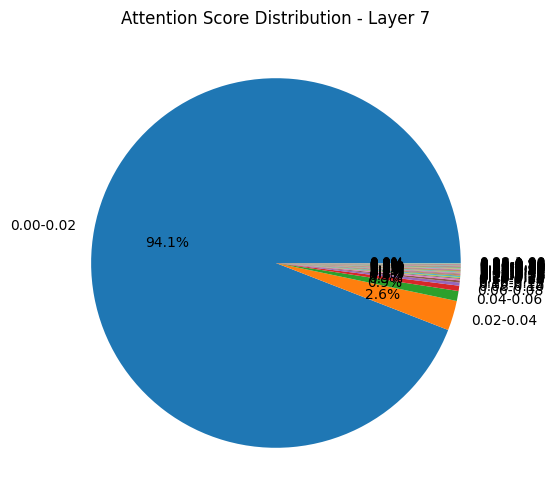

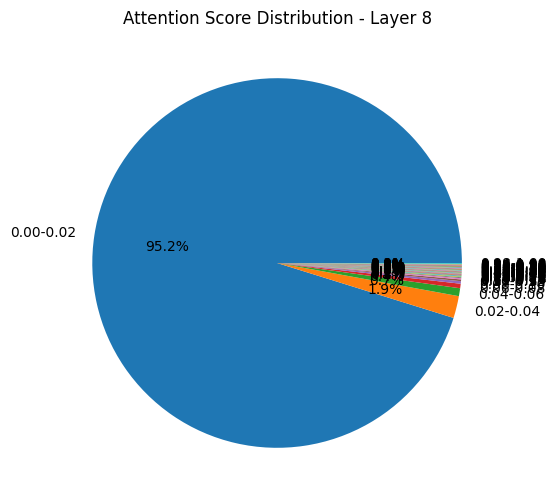

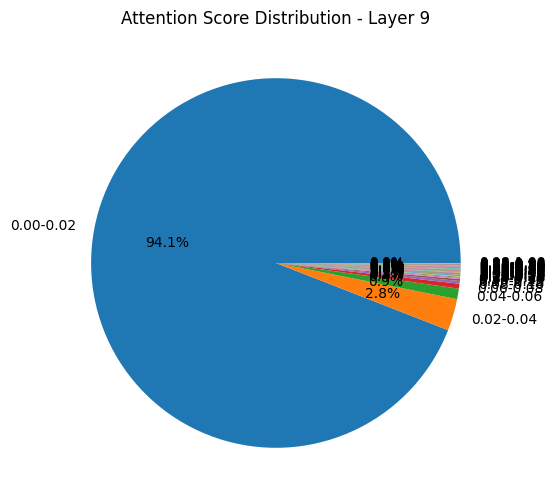

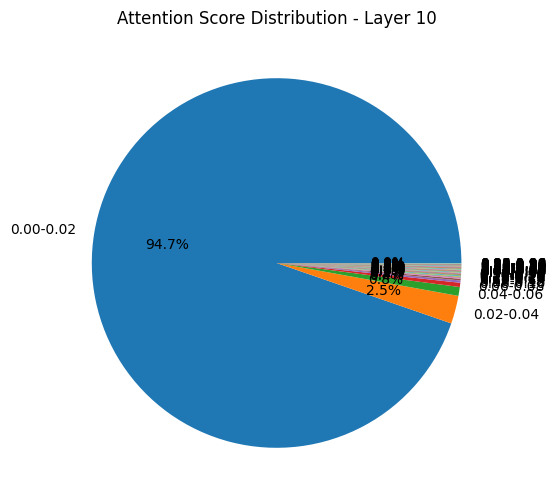

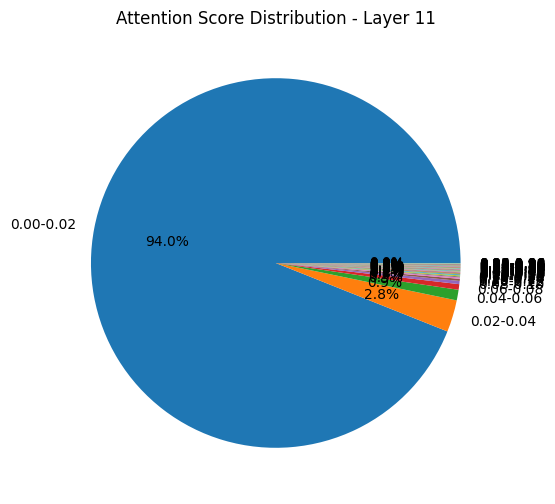

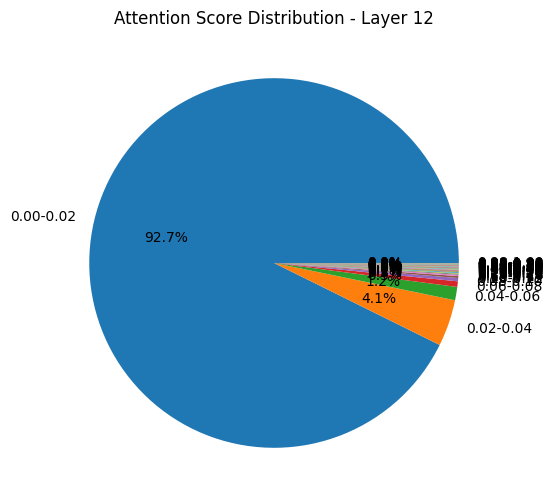

In [27]:
# Process each layer's attention scores
for i, layer_attention in enumerate(attentions):
    # layer_attention is of shape [batch_size, num_heads, sequence_length, sequence_length]
    # For histogram, we consider all heads and all positions
    # plot_attention_histogram(layer_attention[0], i + 1)'

    # only plotting the first batch (since only one sequence) and in tril matrix
    att = layer_attention[0, :, mask]

    plot_attention_piechart(att, i + 1)

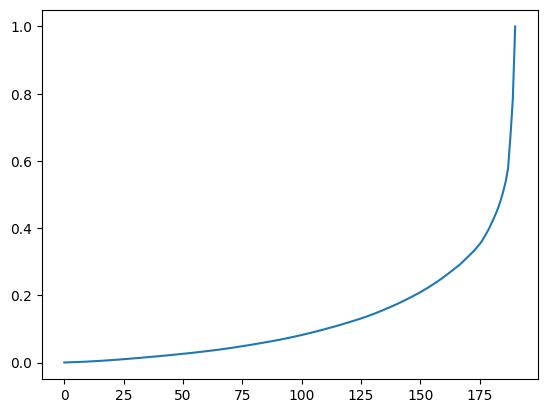

In [51]:
att = layer_attention[0][0][-1].sort().values
att, att.shape
plt.plot(att.cumsum(0))

In [59]:
total_prob = att.cumsum(0)
torch.nonzero(total_prob > .1)[0]

tensor([111])

111 elements needed to cumsum > .1

In [63]:
ten_percent = int(.1 * sequence_length)
total_prob[-ten_percent]

(19, tensor(0.3280))

The top 10% of the sequence makes up ~68% of the sum (in this example)